# Homework 6: Coding

**Due Monday November 9th, 11:59pm.**

**Submit hw6.ipynb file to Gradescope (note there is no autograder for this assignment).**

In [111]:
"""
Import libraries that you might require.
"""
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# **Data Imputation**

## Importing the Data
Here we import the data and randomly set some values to np.NaN.  
You would have to replace these NaNs in later code.  
Remember to use test set to get your accuracies and do not overwrite the train sets or the miss sets.  
You would be copying to a new numpy array each time and then impute it.

In [112]:
iris = load_iris()

X = iris['data']
y = iris['target']

np.random.seed(100)
p = np.random.permutation(len(X))
X, y = X[p], y[p]

X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]


def imputeData(X, y):
    random.seed(42)
    X_miss, y_miss = X.copy(), y.copy()
    for i in range(200):
        sampleId = random.randint(0, X.shape[0] - 1)
        featureId = random.randint(0, X.shape[1] - 1)
        X_miss[sampleId][featureId] = np.NaN
    return X_miss, y_miss


X_miss, y_miss = imputeData(X_train, y_train)

## 1.1 Zero Imputation  
Complete the `zeroImpute` method which takes in the data with missing value and replaces the missing values with zeroes.  
Then train a logistic classifier on this imputed data.
Report the accuracy on test set (`X_test`) and Frobenius norm of difference between the imputed data (`X_Zero`) and the original data without missing values (`X_train`).

In [113]:
def zeroImpute(X_miss):
    '''
    Returns :
    X_imputed which has zeroes instead of missing values and same shape as X_miss.
    '''
    X_imputed = X_miss.copy()

    # replace missing values with zeroes
    X_imputed = np.nan_to_num(X_imputed)

    assert X_imputed.shape == X_miss.shape

    return X_imputed


X_zero = zeroImpute(X_miss)
print('Frobenius norm for zero imputation is {0}'.format(LA.norm(X_zero - X_train)))

# train a logistic regression classifier.
clf = LogisticRegression()
clf.fit(X_zero, y_miss)

print('Accuracy for zero imputation is {0}%'.format(clf.score(X_test, y_test)*100))

Frobenius norm for zero imputation is 51.668172021080835
Accuracy for zero imputation is 60.0%


## 1.2 Mean Imputation  
Complete the `meanImpute` method which takes in the data with missing value and replaces the missing values with mean for that column (ignoring the NaNs).  
Then train a logistic classifier on this imputed data.
Report the accuracy on test set (`X_test`) and Frobenius norm of difference between the imputed data (`X_mean`) and the original data without missing values (`X_train`).

In [114]:
def meanImpute(X_miss):
    '''
    Returns :
    X_imputed which has mean of the corresponding column instead of the missing values and same shape as X_miss.
    '''
    X_imputed = X_miss.copy()

    # replace the value of NaNs with the mean of their column.
    X_imputed = np.apply_along_axis(lambda val: 
                                   np.nan_to_num(val, nan=np.nanmean(val)),
                                   0, X_imputed)

    assert X_imputed.shape == X_miss.shape

    return X_imputed

In [115]:
X_mean = meanImpute(X_miss)
print('Frobenius norm for mean imputation is {0}'.format(LA.norm(X_mean - X_train)))

# train a logistic regression classifier.
clf = LogisticRegression()
clf.fit(X_mean, y_miss)

print('Accuracy for mean imputation is {0}%'.format(clf.score(X_test, y_test)*100))

Frobenius norm for mean imputation is 13.763290287353101
Accuracy for mean imputation is 84.0%


## 1.3 Regression Imputation  
Complete the `regressedImpute` method which takes in the data with missing value and replaces the missing values with values predicted by a linear classifier trained on rows which do not have missing data for the given column to predict the values of given column.  
It does this by iterating through a columns and replacing the missing data (in a copy) with a different model for each feature.   

The method should also train a logistic classifer during the run and store the its accuracy on test set (`X_test`) and the Frobenius norm of difference between the imputed data (`X_imputed`) and the original data without missing values (`X_train`).  
  

Finally train a logistic classifier on the completely imputed data.
Report the accuracy on test set (`X_test`) and Frobenius norm of difference between the imputed data (`X_regressed`) and the original data without missing values (`X_train`).  

Repeat the process again with the imputed data to impute it a second time and observe the differences.

In [118]:
def regressedImpute(X_baseImputed, X_miss, X_test, y_test, computePerFeatureStatistics = False):
    '''
    Returns :
    X_imputed which has mean of the linearly regressed value instead of the missing values and 
    same shape as X_miss.
    if computePerFeatureStatistics is True, also:
    list of Frobenius norms of difference between reconstructions and original data 
    (without missing values) calculated after each imputing each column.
    list of accuracies on test set of Logistic Regression classifier trained on imputed data 
    after each imputing each column.
    '''
    X_imputed = X_baseImputed.copy()
    frobenius_norms =[]
    accuracies =[]
    
    # We do a linear regression based imputation here, for each column, train a 
    # classifier to predict its value based on values of other features and
    # replace the NaN with the predicted values. 
    # IMPORTANT : You should not use regressed values from an earlier column to predict a 
    #             later column, make sure to train the regression model on base imputed
    #             and not modify base imputed during the run.
    #             You can use X_miss to find which values were originally NaNs.
    for i in range(X_baseImputed.shape[1]):
        
        nan_ix = np.isnan(X_miss[:, i])
        x_train = np.delete(X_baseImputed, i, axis=1)
        y_train = X_baseImputed[:, i]
        
        m = LinearRegression()
        m.fit(x_train, y_train)
        pred = m.predict(x_train)
        
        X_imputed[nan_ix, i] = pred[nan_ix]

        if computePerFeatureStatistics == True:
            clf = LogisticRegression()
            clf.fit(X_imputed, y_miss)
            acc = clf.score(X_test, y_test)*100
            accuracies.append(acc)
            frobenius_norms.append(LA.norm(X_train - X_imputed))
            

    if computePerFeatureStatistics == True:
        return X_imputed, frobenius_norms, accuracies
    else:
        return X_imputed

In [125]:
plt.rcParams["figure.figsize"] = (10,5)

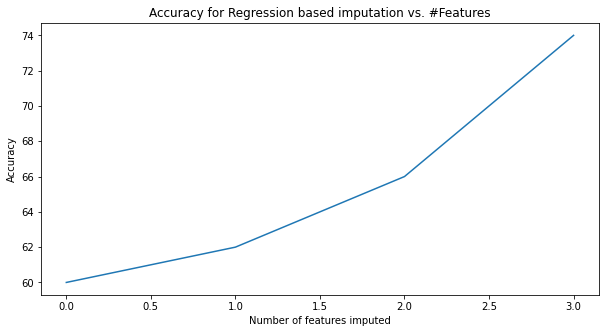

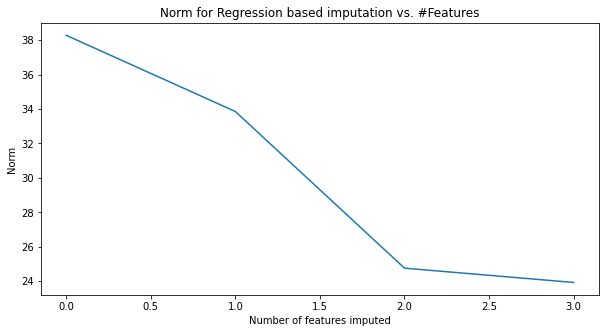

Frobenius norm and accuracy for regression based imputationafter base imputation are 51.668172021080835 and 60.0%
Frobenius norm and accuracy for regression based imputation for stepnumber 1 are 23.929540114599757 and 74.0%
Frobenius norm and accuracy for regression based imputation for stepnumber 2 are 13.985749811313156 and 84.0%
Frobenius norm and accuracy for regression based imputation for stepnumber 3 are 11.394052236880267 and 86.0%
Frobenius norm and accuracy for regression based imputation for stepnumber 4 are 10.489573045629564 and 90.0%
Frobenius norm and accuracy for regression based imputation for stepnumber 5 are 10.046978227018046 and 92.0%


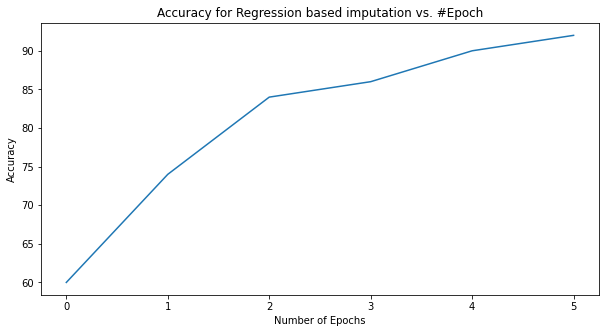

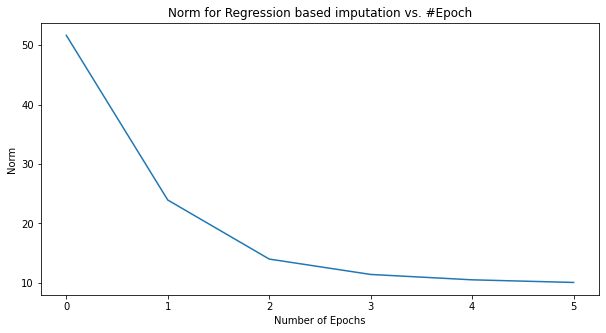

In [126]:
norms =[]
accuracies = []
X_regressed = zeroImpute(X_miss)
X_regressed, norms, accuracies = regressedImpute(X_regressed, X_miss, X_test, y_test, True)
plt.plot(accuracies)
plt.title("Accuracy for Regression based imputation vs. #Features")
plt.ylabel('Accuracy')
plt.xlabel('Number of features imputed')
plt.show()
plt.plot(norms)
plt.title("Norm for Regression based imputation vs. #Features")
plt.ylabel('Norm')
plt.xlabel('Number of features imputed')
plt.show()


epochs = 5
norms =[]
accuracies = []

# impute dataset with zeros initially, then train a  logistic regression 
# classifier and store the norm of difference between the imputed 
# data and the original data without missing values and the accuracy 
# of the classifier on the test set in appropriate variables.

X_imputed = zeroImpute(X_miss)

clf = LogisticRegression()
clf.fit(X_zero, y_miss)
accuracy = clf.score(X_test, y_test)*100
norm = LA.norm(X_zero - X_train)

norms.append(norm)
accuracies.append(accuracy)
print('Frobenius norm and accuracy for regression based imputation' +
      'after base imputation are {0} and {1}%'.format(norm,accuracy))


# Here we show how repeated imputation using regression affect our dataset. For each epoch 
# re-impute the data from previous epoch.

for i in range(epochs):

    # Same as 1.3.3 but this time impute the data with the regression method you completed.
    X_imputed, frobenius, reg_accuracies = regressedImpute(X_imputed, 
                                                           X_miss, 
                                                           X_test, 
                                                           y_test, 
                                                           computePerFeatureStatistics=True)
    norm = frobenius[-1]
    accuracy = reg_accuracies[-1]
    
    norms.append(norm)
    accuracies.append(accuracy)
    print('Frobenius norm and accuracy for regression based imputation for step' + 
          'number {0} are {1} and {2}%'.format(i + 1, norm,accuracy))
  


plt.plot(accuracies)
plt.title("Accuracy for Regression based imputation vs. #Epoch")
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.show()
plt.plot(norms)
plt.title("Norm for Regression based imputation vs. #Epoch")
plt.ylabel('Norm')
plt.xlabel('Number of Epochs')
plt.show()

## 1.4 Follow Up Questions

Complete the 4 follow up questions in your Latex file. 

## Question 2: K-means

We will implement the k-means clustering algorithm using the Breast Cancer dataset. As with all unsupervised learning problems, our goal is to discover and describe some hidden structure in unlabeled data. The K-means algorithm, in particular, attempts to determine how to separate the data into <em>k</em> distinct groups over a set of features ***given that there are k groups***.

Knowing there are <em>k</em> distinct 'classes' however, doesn't tell anything about the content/properties within each class. If we could find samples that were representative of each of the *k* groups, then we could label the rest of the data based on how similar they are to each of the prototypical samples. Armed with this intuition, we can better understand the iterative k-means clustering process which will be used to find these representative samples (prototypes).

We can define such prototypes using the following metrics:
- centroid – the average of similar points w.r.t. continuous features (e.g. petal lengths in the iris dataset)
- medioid – the most representative/most frequently occurring point w.r.t. categorical features (e.g. discrete color labels, blue vs. red vs. green.)

### Import the Data ###

In [127]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random

In [128]:
# Read data (Breast Cancer Dataset). Remember to comment out the code not contained in a function.
from sklearn.datasets import load_breast_cancer

breast = load_breast_cancer()

X = breast['data']
y = breast['target']

np.random.seed(100)
p = np.random.permutation(len(X))
X, y = X[p], y[p]

X_train, y_train = X[:400], y[:400]
X_val, y_val = X[400:500], y[400:500]
X_test, y_test = X[500:], y[500:]

### K-means algorithm

To implement K-means, we divided the algorithm into two functions: a helper method **kmeans_iter()** to update the centroid values and clusters at each interval, and **kmeans()** to run the helper function<br>  
<br>
The K-means process you should follow is listed below:
1. Initialize each centroid to a random datapoint
2. Update each node's cluster to that whose *centroid* is closest
3. Calculate the new *centroid* of each cluster
4. Repeat the previous 2 steps until no centroid value changes


*Hint: you can use the `distance.euclidean(a, b)`   function from scipy to calculate the euclidean distances between lists.*

If the **kmeans_iter()** function returns less than k centroids, let the updated centroid value of the empty cluster be the same as it was at the beginning of the iteration.

### 2.1 `kmeans_iter` function



In [129]:
def kmeans_iter(X, centroids):
    """
    Performs one iteration of the k-means clustering algorithm.
    
    INPUT:
      X - m by n matrix, where m is the number of training points
      centroids - a list of the centroid values
    
    OUTPUT:
      clusters - an updated list of the list of indices in X for each cluster 
      updated_centroids - an updated list of the new centroid values
    """
    
    # initialize data structures
    clusters = [0] * len(X)
    updated_centroids = [[0 for _ in range(len(X[0]))] for _ in range(len(centroids))]
    n_in_cluster = [0] * len(centroids)
   

    # convert lists to np arrays for easier indexing
    X = np.asarray(X).astype(float)
    updated_centroids = np.asarray(updated_centroids).astype(float)
    centroids = np.asarray(centroids).astype(float)
    clusters = np.asarray(clusters).astype(float)
    
    # number of classes in the data set
    classes = centroids.shape[0]
    
    # norm of the clusters
    norm = np.empty([X.shape[0], 1])
    
    for c in range(classes):
        c_norm = np.linalg.norm(X - centroids[c], ord = 2, axis = 1)
        # increase the dimension of c_norm by 1
        c_norm = c_norm[:, np.newaxis]
        if c == 0: # norm is the class norm
            norm = c_norm
        else: # concatenate the class norm to the norm vector
            norm = np.concatenate((norm, c_norm), axis = 1)
    clusters = np.argmin(norm, axis = -1)
    
    # update centroids
    for c in range(classes):
        c_ix = np.argwhere(clusters == c).squeeze()
        c_x = X[c_ix]
        if(c_x.size):
            updated_centroids[c, :] = np.average(c_x, axis = 0)
        else:
            updated_centroids[c, :] = centroids[c]
    
    # back to original python list format
    clusters = np.ndarray.tolist(clusters)
    updated_centroids = np.ndarray.tolist(updated_centroids)
    
    return (clusters, updated_centroids)    

#### Question 2.1.1

Check kmeans_iter with several initial parameters and paste your results into the table of your Latex document.

In [131]:
### 2.1.1: check kmeans_iter and paste your results into your Latex document.

X1 = [[1], [2], [10], [12]]

init1 = [1,2]
init2 = [1,8]
init3 = [2,2]

X2 = [[0,5,0],[0,5,0],[0,4,3],[0,3,4]]
init4 = [[2.5,0,0],[-2.5,0,0]]

print(kmeans_iter(X1, init1))
print(kmeans_iter(X1, init2))
print(kmeans_iter(X1, init3))
print(kmeans_iter(X2, init4))

([0, 1, 1, 1], [[1.0], [8.0]])
([0, 0, 1, 1], [[1.5], [11.0]])
([0, 0, 0, 0], [[6.25], [2.0]])
([0, 0, 0, 0], [[0.0, 4.25, 1.75], [-2.5, 0.0, 0.0]])


#### Question 2.1.2

If an iteration of the k-means algorithm returns less than K classes, what might that indicate about the data? Write your response in your Latex document.

### 2.2 Putting the algorithm together

In [97]:
def kmeans(X, k):
    """
    Performs k-means clustering by calling kmeans_iter until no centroid value changes.
    
    INPUT:
      X - m by n matrix, where m is the number of training points
      k - the number of clusters

    OUTPUT:
      clusters - a list of the list of indices in X for each cluster 
      centroids - a list of the centroid values for each cluster
      iters - the number of iterations it took for k-means to converge
    """
    
    # Do not change random seed for consistency of plots when grading
    random.seed(520)
    centroid_init = random.sample(range(0,len(X)), k)
    centroids = [X[centroid_init[i]] for i in range(k)] 
    prev_centroids = None    
    iters = 0
    
    while True:
        iters += 1
        prev_centroids = centroids
        
        (clusters, updated_cents) = kmeans_iter(X, centroids)
        centroids = updated_cents
        
        # Convergence check
        if(np.all(np.asarray(centroids) == 
           np.asarray(prev_centroids))): 
            # Converged in the last iteration
            iters -= 1
            break
        
    return (clusters, centroids, iters)

#### 2.2.1 Sanity Check
Run the code below to make sure your kmeans function is partitioning the data correctly. The points are projected into two demensions using the first 2 PCA components. You should see a clear split between your clusters. Submit these graphs in your writeup under section 4.2.1.

8


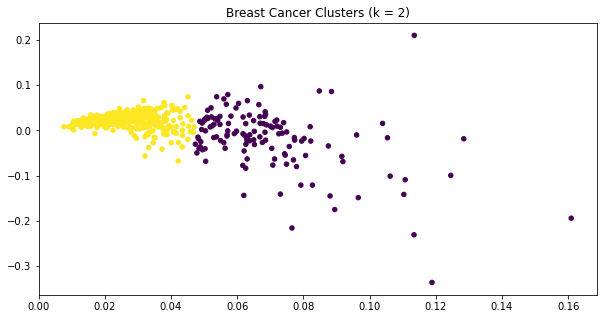

22


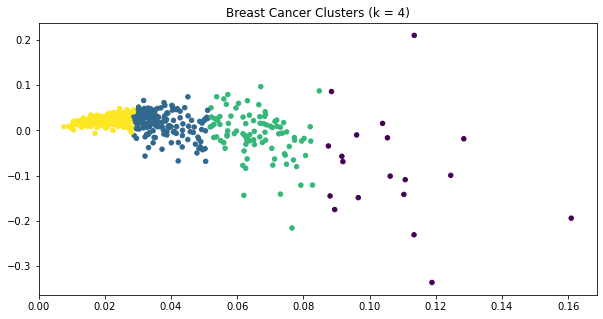

19


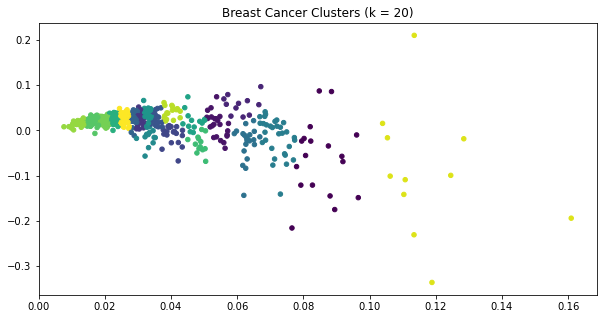

In [132]:
pca = PCA(n_components = 2)
v = pca.fit(np.transpose(X)).components_

for k in [2,4,20]:
    (clusters, centroids, iters) = kmeans(X,k)
    print(iters)
    plt.scatter(v[0], v[1], c=clusters, s= 20)
    plt.title("Breast Cancer Clusters (k = "+str(k) + ")")
    plt.show()

#### Question 2.2.2

Write down how many iterations it took for your kmeans to converge for each of the sanity-check graphs. How does this number compare with what you expected it to be? How does the number of iterations seem to vary proportional to k?

## 2.3 Choosing a Value for K

Now that we can separate our data into K groups, we just need to figure out the best value for K (how many clusters our data really consists of).

## Testing Cluster Distortion 

One way to decide on a value for K is to run K-Means and plot the distortion (sum of squared error given Euclidean distance). From that we can find the "elbow of the graph;" indicating the best tradeoff between number of clusters and distortion.

In the function **test_cluster_size**,  iterate over possible cluster sizes from 2 to a *max_cluster* (inclusive) value. For each *k*, run K-means and calculate its distortion.

In [133]:
def test_cluster_size(X, max_k):
    """
    Iterates over possible cluster from 2 to max_k, running k-means and calulating distortion.
    
    INPUT:
      X - m by n matrix, where m is the number of training points
      max_k - the maximum number of clusters to consider
    
    OUTPUT:
      scores - a list of scores, where score[i] is the distortion for k-means with i clusters
    """
    scores = [0] * (max_k-1)
    
    for k in range(max_k - 1):
        clusters, cents, iters = kmeans(X, k + 2)
        
        for x_i in range(len(X)):
            closest_cent = cents[clusters[x_i]]
            scores[k] += distance.euclidean(X[x_i], closest_cent)
            
    return scores

### Distortion Plot
Run the code below to plot the distortion as *k* increases from (2 to 25). Record your graph in your writeup along with the value of K you would choose.

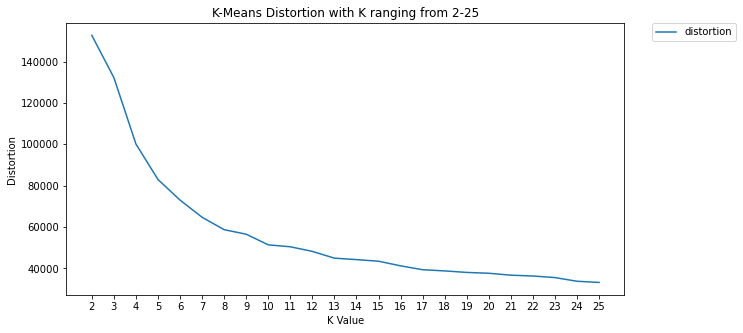

In [134]:
max_k = 25

scores = test_cluster_size(X, max_k)

plt.plot(range(max_k-1), scores, label='distortion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('K-Means Distortion with K ranging from 2-25')
plt.ylabel('Distortion')
plt.xlabel('K Value')
plt.xticks(range(max_k-1), range(2,max_k+1))
plt.show()

### Feature Scaling Using min-max
Given an input matrix X, we can rescale each feature along its min/max value range, as follows:

In [135]:
X_copy = X.copy()
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_copy)

Now plot the distortion as *k* increases from (2 to 25). Record your graph in your writeup along with the value of K you would choose

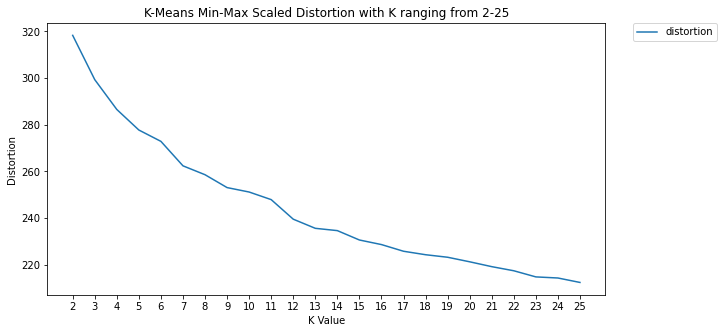

In [136]:
max_k = 25
scores = test_cluster_size(X_scaled, max_k)

plt.plot(range(max_k-1), scores, label='distortion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('K-Means Min-Max Scaled Distortion with K ranging from 2-25')
plt.ylabel('Distortion')
plt.xlabel('K Value')
plt.xticks(range(max_k-1), range(2,max_k+1))
plt.show()

### Log Scaling
As an alternative,  try adding 1 to all elements in the original matrix and then take the numpy log of all elements in the original matrix. This is the NLP-inspired version, since word frequencies are informative but follow a Zipfian distribution. Call this matrix X_log.

Again, plot the number of clusters (from 2 to 25) vs distortion. Find the “elbow” after which the change in distortion tapers off notably.

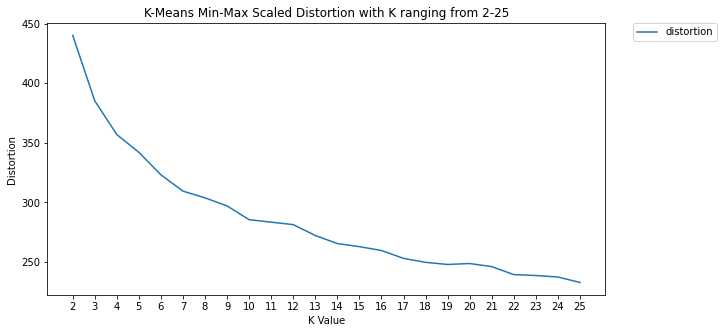

In [137]:
def logarithmize(x):
    return np.log(x + 1)

logarithmize_v=np.vectorize(logarithmize)
X_copy2 = X.copy()
X_log=logarithmize_v(X_copy2)

max_k = 25
scores = test_cluster_size(X_log, max_k)

plt.plot(range(max_k-1), scores, label='distortion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('K-Means Min-Max Scaled Distortion with K ranging from 2-25')
plt.ylabel('Distortion')
plt.xlabel('K Value')
plt.xticks(range(max_k-1), range(2,max_k+1))
plt.show()

#### Question 2.3.2

Why can't we hold out some of the data in a validation set, and choose the value of k which minimizes a cross-validation error like we have in the past for algorithms like linear regression?


# Turning it in

**This notebook will not be autograded, so no need to comment out code outside of functions.**

1. Download this notebook as a `hw6.ipynb` file with the functions implemented and the sandbox code commented out
  - go to "File -> Download .ipynb"
  
2. Submit `hw6.ipynb` file to Gradescope (you can do this as many times as you'd like before the deadline)